## Introduction

This is a Colab Notebook used within the context of the Master Degree Thesis Project of Parrinello Angelo ("streaming materialized view"). Throughout this document, you can find some useful information regarding the structure and implications of the quantitative results ("Performance Analysis") of the benchmarking between ksqlDB, Materialize (Cloud), and Flink (8 parallelism and 24 parallelism).

## Libraries Loading and Utility Functions Definition

Let's start importing the libraries that we will use.

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

To avoid unnecessary code repetition, it is important to define some utility functions used during the plot sections.

In [3]:
def plot_and_log(df, title_prefix):
    df['Log_Throughput'] = np.log(df['Throughput (rows/s)'])
    df['Log_Throughput_bytes'] = np.log(df['Throughput (bytes/s)'])

    fig, axs = plt.subplots(2, 3, figsize=(15, 5))

    columns = ['Throughput (rows/s)', 'Log_Throughput', 'Duration (s)',
               'Log_Throughput_bytes', 'Throughput (bytes/s)']

    titles = [f'{title_prefix} - Throughput per Job',
              f'{title_prefix} - Log Normalized Throughput per Job',
              f'{title_prefix} - Duration per Job',
              f'{title_prefix} - Log Normalized Throughput (in bytes) per Job',
              f'{title_prefix} - Throughput per Job (in bytes)']

    for i in range(5):
        row, column = i // 3, i % 3
        axs[row, column].bar(df['Job Name'], df[columns[i]])
        axs[row, column].set_xlabel('Job Name')
        axs[row, column].set_ylabel(columns[i])
        axs[row, column].set_title(titles[i])
        axs[row, column].tick_params(axis='x', rotation=45)

    axs[1, 2].axis('off')

    plt.tight_layout()

    plt.show()

In [4]:
def generate_comparison_plot(dataframe, comparison_column, title):
    job_names = ["Query " + str(number) for number in range(1, 9)]
    systems = dataframe['System'].unique()
    colors = ['blue', 'yellow', 'green', 'red']
    system_color_map = {system: color for system, color in zip(systems, colors)}

    plt.figure(figsize=(12, 8))

    index = np.arange(len(job_names))
    bar_width = 0.2

    for i, system in enumerate(systems):
        system_df = dataframe[dataframe['System'] == system]

        data = []
        for job_name in job_names:
            job_df = system_df[
                system_df['Job Name'].str.contains(f"{job_name}|{job_name.replace(' ', '')}")
            ]
            if not job_df.empty:
                data.append(job_df[comparison_column].values[0])
            else:
                data.append(np.nan)

        offset = i * bar_width
        plt.bar(index + offset, data, bar_width, label=system, color=system_color_map[system])

    plt.xlabel('Job Name')
    plt.ylabel(comparison_column)
    plt.title(title)
    plt.xticks(index + (bar_width * len(systems) / 2), job_names, rotation=45)
    plt.legend()

    plt.show()

In [5]:
def generate_comparison_multiple_plot(dataframe, comparison_column, title):
    job_names = ["Query " + str(number) for number in range(1, 9)]
    num_rows = 3
    num_cols = 3
    figsize = (15, 12)
    num_plots = num_rows * num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, job_name in enumerate(job_names):
        row = i // num_cols
        col = i % num_cols

        job_df = dataframe[dataframe['Job Name'].str.contains(f"{job_name}|{job_name.replace(' ', '')}")]
        if not job_df.empty:
            axs[row, col].bar(job_df['System'], job_df[comparison_column])
            axs[row, col].set_xlabel('System')
            axs[row, col].set_ylabel(comparison_column)
            axs[row, col].set_title(f'{title} - {job_name}')
            axs[row, col].tick_params(axis='x', rotation=45)

    for i in range(len(job_names), num_plots):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

## Data Loading and Data Cleaning

Before loading, the Excel files into the respective Pandas Dataframes, remember to upload the files into this Colab Runtime Environment (click on the folder symbol on the most left part of the screen and then click on the upload button).

We have two Flink Dataframes due to the double analysis performed (the first one with only 8 cores = 8 job parallelism and the second one with 24).

In [6]:
ksql_df = pd.read_excel('ksqlTestResults.xlsx')
materialize_df = pd.read_excel('materializeResults.xlsx')
flink8_df = pd.read_excel('testBuoni_parallelism8.xlsx')
flink24_df = pd.read_excel('testBuoni_parallelism24.xlsx')

### ksqlDB

In [7]:
ksql_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Starting Time,Finish Time,Duration (s),Rows processed,Bytes processed,Unnamed: 8
0,Query 1,25330.390000,1.041732e+07,11:56:43,12:57:15,1h and 32s (3632),92000000,37835713115,This one is before the queries refactor
1,Query 1,283076.923077,7.043391e+07,18:45:05 = 1696265105022,18:50:30,5m and 25s (325s),92000000,22891019278,NaN
2,Query 2,538011.695906,1.338656e+08,19:43:24 = 1696268604644,19:46:15,2m and 51s (171s),92000000,22891019278,NaN
3,Query3,16460.905350,9.077602e+06,18:08:39 = 1696435719942,18:16:45,8m and 6s (486s),8000000,4411714706,NaN
4,Query4,44748.858447,1.220128e+07,17:25:03 = 1696433103397,18:01:33,36m and 30s (2190s),98000000,26720812121,NaN
5,Query6,45475.638051,1.239945e+07,15:18:20 = 1696425500857,15:54:15,35m and 55s (2155s),98000000,26720812121,NaN
6,Query7,58561.425843,1.457099e+07,16:21:49 = 1696429309815,16:48:00,26 m and 11 s (1571s),92000000,22891019278,NaN
7,Query8,39215.686275,2.162605e+07,17:10:06 = 1696432206280,17:13:30,3 m and 24s (204s),8000000,4411714706,NaN


As you can see there is a lot of useless information or malformatted. In this case, we need to:
- Remove the columns that we will not use during this analysis
- Re-format the column 'Duration (s)'
- Delete the first line which is the query 1 performance results BEFORE the ksqlDB queries refactor (noteworthy the difference in the duration...)

In [8]:
ksql_df['Duration (s)'] = ksql_df['Duration (s)'].str.extract(r'\((\d+)s?\)') # keep only the seconds value
ksql_df['Duration (s)'] = ksql_df['Duration (s)'].astype(int, errors='ignore') # keep only the seconds value
ksql_df.drop(["Starting Time", "Finish Time", "Unnamed: 8"], axis=1, inplace=True) # remove some useless columns
ksql_df.drop(0, inplace=True) # remove the first line which is a line of a previous test

ksql_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
1,Query 1,283076.923077,7.043391e+07,325,92000000,22891019278
2,Query 2,538011.695906,1.338656e+08,171,92000000,22891019278
3,Query3,16460.905350,9.077602e+06,486,8000000,4411714706
4,Query4,44748.858447,1.220128e+07,2190,98000000,26720812121
5,Query6,45475.638051,1.239945e+07,2155,98000000,26720812121
6,Query7,58561.425843,1.457099e+07,1571,92000000,22891019278
7,Query8,39215.686275,2.162605e+07,204,8000000,4411714706


### Materialize

In [9]:
materialize_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Starting Time,Finish Time,Duration (s),Rows processed,Bytes processed
0,Query1,340740.740741,1.399841e+08,15:24:30 = 1697030670,15:29:00 = 1697030940,4m and 30s (270s),92000000,37795695846
1,Query2,630136.986301,2.588746e+08,15:48:34 = 1697032114,15:51:00 = 1697032260,2m and 26s (146s),92000000,37795695846
2,Query3,48192.771084,3.528171e+07,16:03:54 = \t1697033034,16:06:45 = 1697033205,2 m and 51s (166s),8000000,5856763536
3,Query4,492462.311558,2.145947e+08,16:18:41 = 1697033921,16:22:00 = 1697034120,3m and 19s (199s),98000000,42704349263
4,Query5,143079.315708,5.878024e+07,16:40:17 = 1697035217,16:51:00 = 1697035860,10m and 43s(643s),92000000,37795695846
5,Query6,433628.318584,1.889573e+08,16:59:14 = 1697036354,17:03:00 = 1697036580,3m and 46s(226s),98000000,42704349263
6,Query7,312925.170068,1.285568e+08,17:12:06 = 1697037126,17:17:00 = 1697037420,4m and 54s (294s),92000000,37795695846
7,Query8,76923.076923,5.631503e+07,17:45:16 = 1697039116,17:47:00 = 1697039220,1m and 44s (104s),8000000,5856763536


As you can see there is a lot of useless information or malformatted. In this case, we need to:
- Remove the columns that we will not use during this analysis
- Re-format the column 'Duration (s)'

In [10]:
materialize_df['Duration (s)'] = materialize_df['Duration (s)'].str.extract(r'\((\d+)s?\)') # keep only the seconds value
materialize_df['Duration (s)'] = materialize_df['Duration (s)'].astype(int, errors='ignore') # keep only the seconds value
materialize_df.drop(["Starting Time", "Finish Time"], axis=1, inplace=True) # remove some useless columns

materialize_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
0,Query1,340740.740741,1.399841e+08,270,92000000,37795695846
1,Query2,630136.986301,2.588746e+08,146,92000000,37795695846
2,Query3,48192.771084,3.528171e+07,166,8000000,5856763536
3,Query4,492462.311558,2.145947e+08,199,98000000,42704349263
4,Query5,143079.315708,5.878024e+07,643,92000000,37795695846
5,Query6,433628.318584,1.889573e+08,226,98000000,42704349263
6,Query7,312925.170068,1.285568e+08,294,92000000,37795695846
7,Query8,76923.076923,5.631503e+07,104,8000000,5856763536


### Flink

In [11]:
flink8_df

,Job Id,Job Name,Throughput (rows/s),Throughput (bytes/s),Running time (s),Preprocessing/Overhead (s),Duration (s),Rows processed,Bytes processed
0,eb08f37c76eafe4c279b3ae8eb0b62c6,insert-into_default_catalog.default_database.n...,127958.341215,3.593584e+07,718.981,0.003,718.984,92000000,25837291390
1,c4c864895ab2d49efadc4e1ce7f32b04,insert-into_default_catalog.default_database.n...,129040.583263,3.623977e+07,712.854,0.100,712.954,92000000,25837291390
2,911081a956980e099c4e0501773b2db3,insert-into_default_catalog.default_database.n...,37787.539559,2.049920e+07,211.601,0.109,211.710,8000000,4339885953
3,96467940a892be5cdec3082706df1175,insert-into_default_catalog.default_database.n...,34912.295327,1.051412e+07,2806.903,0.131,2807.034,98000000,29513487592
4,fc99fbbcbbb4c714a45ae61b93820ca6,insert-into_default_catalog.default_database.n...,43103.367500,1.210000e+07,2134.289,0.115,2134.404,92000000,25837291364
5,a9b94e29da1c4500da7f58ae3e3fca41,insert-into_default_catalog.default_database.n...,29613.168332,8.316566e+06,3106.720,0.006,3106.726,92000000,25837291364
6,be22ffc6128acc4c429585658c9bbc19,insert-into_default_catalog.default_database.n...,33390.514590,1.811388e+07,239.586,0.003,239.589,8000000,4339885953


As you can see there is a lot of useless information or malformatted. In this case, we need to:
- Remove the columns that we will not use during this analysis
- Re-format the column 'Duration (s)'
- Normalize the Job Name, following the standard format used with ksqlDB and Materialize

In [12]:
flink8_df.drop(["Job Id", "Running time (s)", "Preprocessing/Overhead (s)"], axis=1, inplace=True) # remove some useless columns

queries_number = flink8_df["Job Name"].str.extract(r'nexmark_q(\d+)$').values.flatten()
queries_name = ["Query " + str(i) for i in queries_number]

flink8_df['Job Name'] = queries_name

flink8_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
0,Query 2,127958.341215,3.593584e+07,718.984,92000000,25837291390
1,Query 1,129040.583263,3.623977e+07,712.954,92000000,25837291390
2,Query 3,37787.539559,2.049920e+07,211.710,8000000,4339885953
3,Query 4,34912.295327,1.051412e+07,2807.034,98000000,29513487592
4,Query 5,43103.367500,1.210000e+07,2134.404,92000000,25837291364
5,Query 7,29613.168332,8.316566e+06,3106.726,92000000,25837291364
6,Query 8,33390.514590,1.811388e+07,239.589,8000000,4339885953


In [13]:
flink24_df

,Job Id,Job Name,Throughput (rows/s),Throughput (bytes/s),Running time (s),Preprocessing/Overhead (s),Duration (s),Rows processed,Bytes processed
0,896fcd261b9a8a02d1f06d6f15209baf,insert-into_default_catalog.default_database.n...,189065.052764,5.314798e+07,486.505,0.100,486.605,92000000,25862073976
1,32e6049e47576cc3b34f14bb43fb2190,insert-into_default_catalog.default_database.n...,189449.320248,5.325600e+07,485.611,0.007,485.618,92000000,25862073976
2,a6933b1f3b7f554b9896c6d4c4763534,insert-into_default_catalog.default_database.n...,102256.023519,5.547566e+07,78.232,0.003,78.235,8000000,4340138224
3,68db1625b3eecc8a5d9a3f030f9b3954,insert-into_default_catalog.default_database.n...,114277.718177,3.444486e+07,857.556,0.004,857.560,98000000,29538532343
4,0fd4e1ac7098a21a9893d3d96a1e51aa,insert-into_default_catalog.default_database.n...,155840.548017,4.380826e+07,590.343,0.004,590.347,92000000,25862073976
5,54ce8d15b264b9cee77e1ccaf27365c4,insert-into_default_catalog.default_database.n...,105096.014348,2.954349e+07,875.386,0.004,875.390,92000000,25862073976
6,5dc189264a7bac4ec701b764adbd2d11,insert-into_default_catalog.default_database.n...,105494.969209,5.723284e+07,75.829,0.004,75.833,8000000,4340138224


In [14]:
flink24_df.drop(["Job Id", "Running time (s)", "Preprocessing/Overhead (s)"], axis=1, inplace=True) # remove some useless columns

queries_number = flink24_df["Job Name"].str.extract(r'nexmark_q(\d+)$').values.flatten()
queries_name = ["Query " + str(i) for i in queries_number]

flink24_df['Job Name'] = queries_name

flink24_df

,Job Name,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
0,Query 1,189065.052764,5.314798e+07,486.605,92000000,25862073976
1,Query 2,189449.320248,5.325600e+07,485.618,92000000,25862073976
2,Query 3,102256.023519,5.547566e+07,78.235,8000000,4340138224
3,Query 4,114277.718177,3.444486e+07,857.560,98000000,29538532343
4,Query 5,155840.548017,4.380826e+07,590.347,92000000,25862073976
5,Query 7,105096.014348,2.954349e+07,875.390,92000000,25862073976
6,Query 8,105494.969209,5.723284e+07,75.833,8000000,4340138224


## Data Analysis

### ksqlDB

In [15]:
ksql_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 1 to 7
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job Name              7 non-null      object 
 1   Throughput (rows/s)   7 non-null      float64
 2   Throughput (bytes/s)  7 non-null      float64
 3   Duration (s)          7 non-null      int64  
 4   Rows processed        7 non-null      int64  
 5   Bytes processed       7 non-null      int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 855.0 bytes


In [16]:
ksql_df.describe()

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
count,7.000000,7.000000e+00,7.000000,7.000000e+00,7.000000e+00
mean,146507.304707,3.916784e+07,1014.571429,6.971429e+07,1.870544e+10
std,195212.347212,4.691680e+07,923.341551,4.224419e+07,9.913549e+09
min,16460.905350,9.077602e+06,171.000000,8.000000e+06,4.411715e+09
25%,41982.272361,1.230037e+07,264.500000,5.000000e+07,1.365137e+10
50%,45475.638051,1.457099e+07,486.000000,9.200000e+07,2.289102e+10
75%,170819.174460,4.602998e+07,1863.000000,9.500000e+07,2.480592e+10
max,538011.695906,1.338656e+08,2190.000000,9.800000e+07,2.672081e+10


In [17]:
ksql_df.corr(numeric_only=True)

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
Throughput (rows/s),1.000000,0.996344,-0.510866,0.378331,0.310830
Throughput (bytes/s),0.996344,1.000000,-0.566448,0.309347,0.241667
Duration (s),-0.510866,-0.566448,1.000000,0.540018,0.612067
Rows processed,0.378331,0.309347,0.540018,1.000000,0.993948
Bytes processed,0.310830,0.241667,0.612067,0.993948,1.000000


These are the performance of ksqlDB during the execution of Query 1,2,3,4,6,7,8 of the Nexmark Benchmark. As you can see, we were not able to reproduce the Query 5 in ksqlDB.

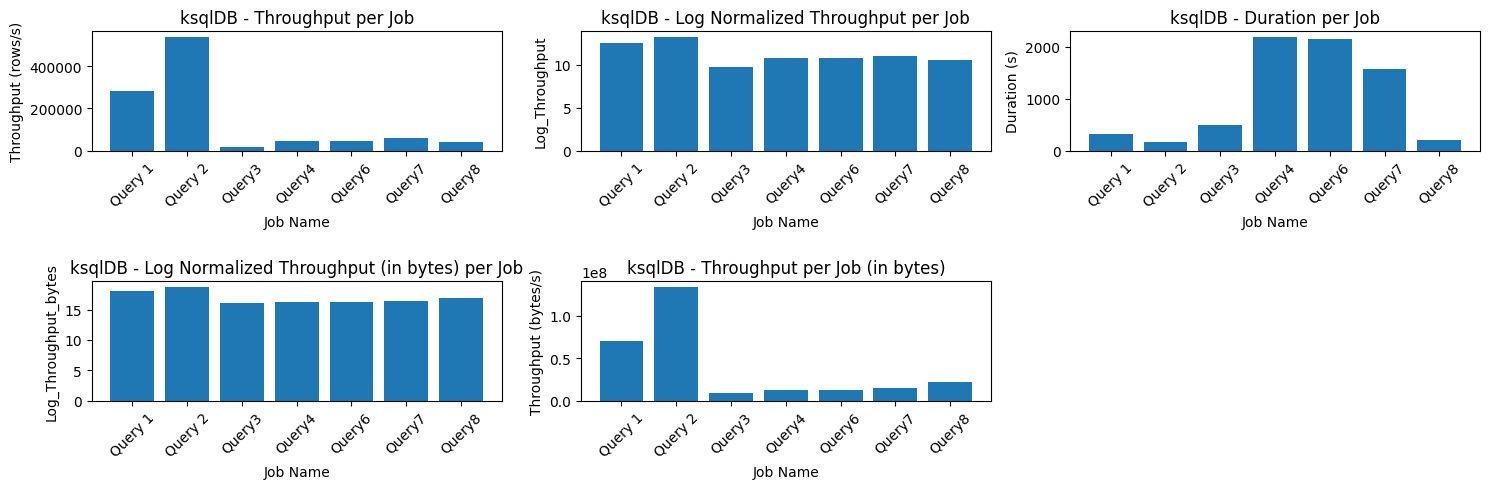

In [18]:
plot_and_log(ksql_df, 'ksqlDB')

### Materialize

In [19]:
materialize_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job Name              8 non-null      object 
 1   Throughput (rows/s)   8 non-null      float64
 2   Throughput (bytes/s)  8 non-null      float64
 3   Duration (s)          8 non-null      int64  
 4   Rows processed        8 non-null      int64  
 5   Bytes processed       8 non-null      int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 952.0 bytes


In [20]:
materialize_df.describe()

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
count,8.000000,8.000000e+00,8.000000,8.000000e+00,8.000000e+00
mean,309761.086371,1.351681e+08,256.000000,7.250000e+07,3.103813e+10
std,207965.529920,8.159331e+07,168.549272,3.989629e+07,1.568923e+10
min,48192.771084,3.528171e+07,104.000000,8.000000e+06,5.856764e+09
25%,126540.256011,5.816394e+07,161.000000,7.100000e+07,2.981096e+10
50%,326832.955404,1.342704e+08,212.500000,9.200000e+07,3.779570e+10
75%,448336.816828,1.953667e+08,276.000000,9.350000e+07,3.902286e+10
max,630136.986301,2.588746e+08,643.000000,9.800000e+07,4.270435e+10


In [21]:
materialize_df.corr(numeric_only=True)

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
Throughput (rows/s),1.000000,0.994733,-0.221671,0.746729,0.757262
Throughput (bytes/s),0.994733,1.000000,-0.296249,0.693969,0.710042
Duration (s),-0.221671,-0.296249,1.000000,0.420765,0.394480
Rows processed,0.746729,0.693969,0.420765,1.000000,0.997460
Bytes processed,0.757262,0.710042,0.394480,0.997460,1.000000


These are the performance of Materialize during the execution of Query 1-8 of the Nexmark Benchmark. As you can see, we were able to reproduce all the Nexmark Queries.

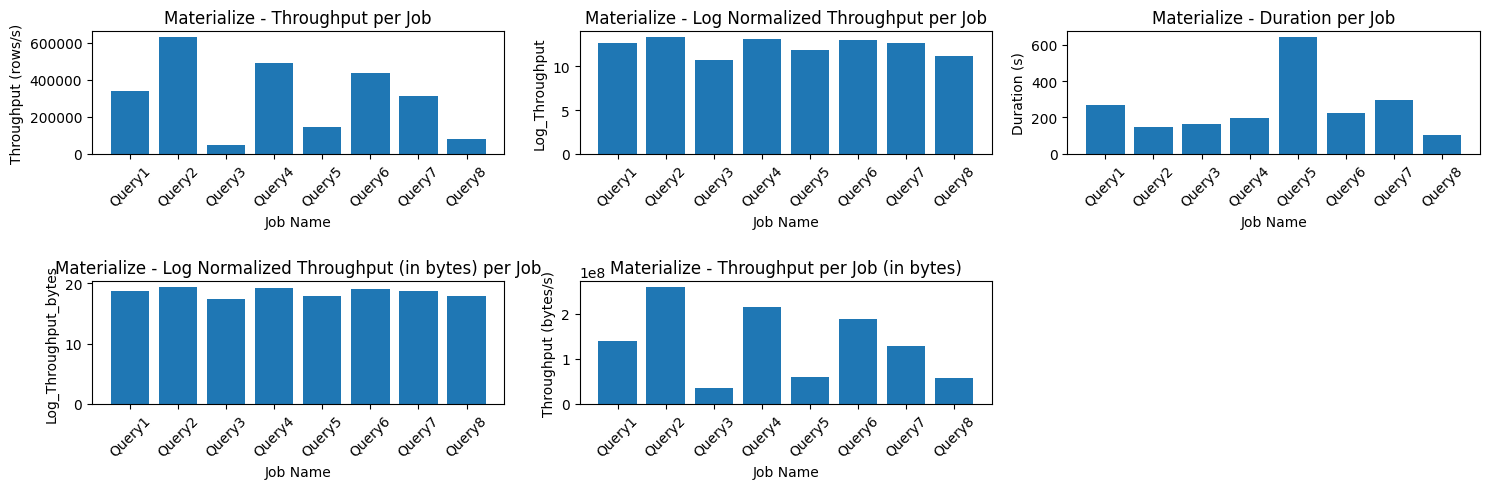

In [22]:
plot_and_log(materialize_df, 'Materialize')

### Flink

In [23]:
flink8_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job Name              7 non-null      object 
 1   Throughput (rows/s)   7 non-null      float64
 2   Throughput (bytes/s)  7 non-null      float64
 3   Duration (s)          7 non-null      float64
 4   Rows processed        7 non-null      int64  
 5   Bytes processed       7 non-null      int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 856.0 bytes


In [24]:
flink24_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job Name              7 non-null      object 
 1   Throughput (rows/s)   7 non-null      float64
 2   Throughput (bytes/s)  7 non-null      float64
 3   Duration (s)          7 non-null      float64
 4   Rows processed        7 non-null      int64  
 5   Bytes processed       7 non-null      int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 856.0 bytes


In [25]:
flink8_df.describe()

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
count,7.000000,7.000000e+00,7.000000,7.000000e+00,7.000000e+00
mean,62257.972827,2.024562e+07,1418.771571,6.885714e+07,2.022035e+10
std,45440.356432,1.161866e+07,1233.149272,4.163103e+07,1.093115e+10
min,29613.168332,8.316566e+06,211.710000,8.000000e+06,4.339886e+09
25%,34151.404958,1.130706e+07,476.271500,5.000000e+07,1.508859e+10
50%,37787.539559,1.811388e+07,718.984000,9.200000e+07,2.583729e+10
75%,85530.854357,2.821752e+07,2470.719000,9.200000e+07,2.583729e+10
max,129040.583263,3.623977e+07,3106.726000,9.800000e+07,2.951349e+10


In [26]:
flink24_df.describe()

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
count,7.000000,7.000000e+00,7.000000,7.000000e+00,7.000000e+00
mean,137354.235183,4.670130e+07,492.798286,6.885714e+07,2.023816e+10
std,39894.999778,1.099551e+07,325.257836,4.163103e+07,1.094307e+10
min,102256.023519,2.954349e+07,75.833000,8.000000e+06,4.340138e+09
25%,105295.491778,3.912656e+07,281.926500,5.000000e+07,1.510111e+10
50%,114277.718177,5.314798e+07,486.605000,9.200000e+07,2.586207e+10
75%,172452.800390,5.436583e+07,723.953500,9.200000e+07,2.586207e+10
max,189449.320248,5.723284e+07,875.390000,9.800000e+07,2.953853e+10


In [27]:
flink8_df.corr(numeric_only=True)

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
Throughput (rows/s),1.000000,0.936277,-0.405430,0.380279,0.351005
Throughput (bytes/s),0.936277,1.000000,-0.692559,0.034242,0.006038
Duration (s),-0.405430,-0.692559,1.000000,0.677786,0.697362
Rows processed,0.380279,0.034242,0.677786,1.000000,0.997519
Bytes processed,0.351005,0.006038,0.697362,0.997519,1.000000


In [28]:
flink24_df.corr(numeric_only=True)

,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed
Throughput (rows/s),1.000000,0.309337,0.105122,0.550512,0.517749
Throughput (bytes/s),0.309337,1.000000,-0.905625,-0.617229,-0.637942
Duration (s),0.105122,-0.905625,1.000000,0.886664,0.900787
Rows processed,0.550512,-0.617229,0.886664,1.000000,0.997528
Bytes processed,0.517749,-0.637942,0.900787,0.997528,1.000000


These are the performance of Flink during the execution of Query 1,2,3,4,5,7,8 of the Nexmark Benchmark. As you can see, we were not able to reproduce the Query 6 in Flink.

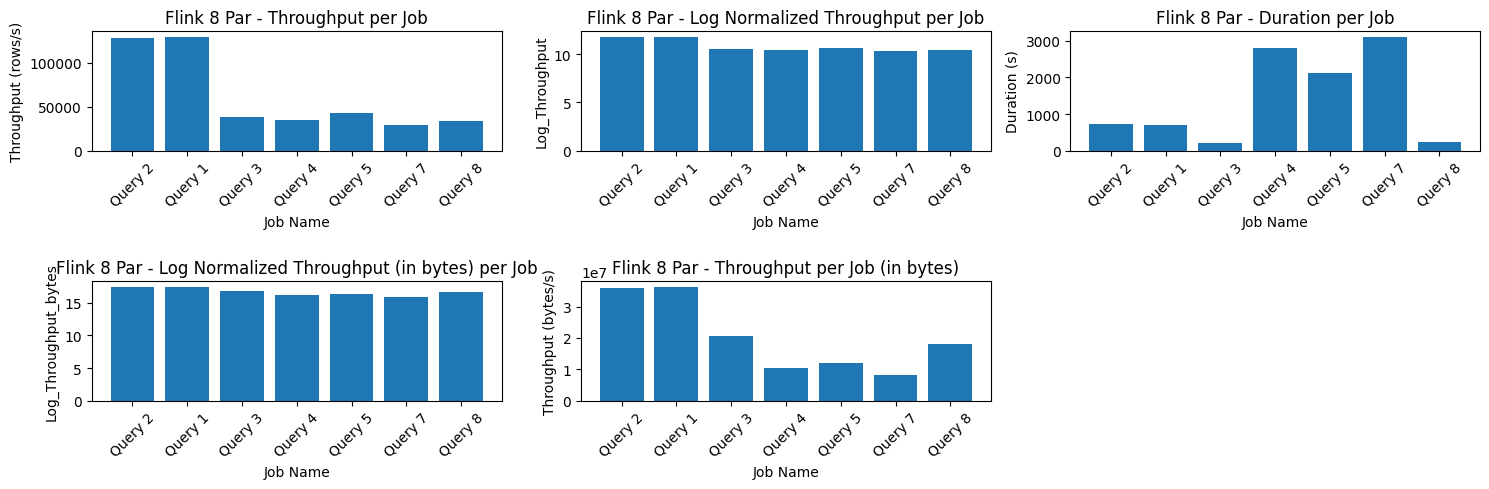

In [29]:
plot_and_log(flink8_df, 'Flink 8 Par')

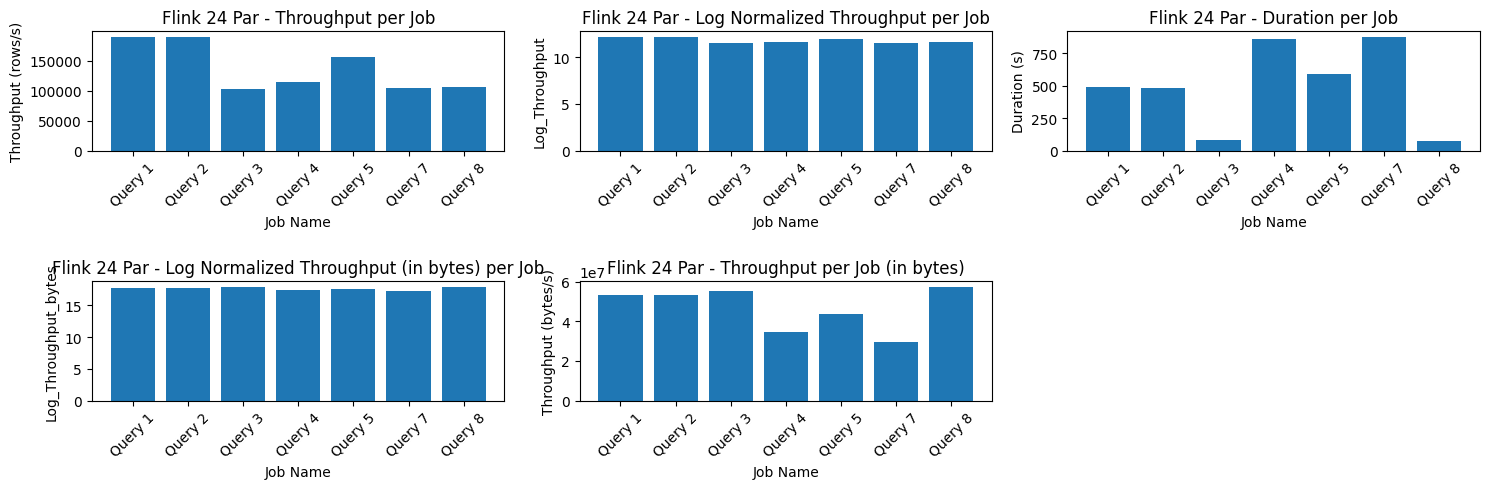

In [30]:
plot_and_log(flink24_df, 'Flink 24 Par')

## Data Comparison

This section could be included in the previous one (Analysis) but I wanted to separated them just because I want to get a deeper focus on the Comparison part.

For an easier use, I combined all the previous dataframes.

In [31]:
combined_df = pd.concat([ksql_df, materialize_df, flink8_df, flink24_df], keys=['ksqlDB', 'Materialize', 'Flink 8', 'Flink 24'])

combined_df = combined_df.reset_index(level=0)
combined_df.rename(columns={'level_0': 'System'}, inplace=True)
combined_df

,System,Job Name,Throughput (rows/s),Throughput (bytes/s),Duration (s),Rows processed,Bytes processed,Log_Throughput,Log_Throughput_bytes
1,ksqlDB,Query 1,283076.923077,7.043391e+07,325.000,92000000,22891019278,12.553474,18.070185
2,ksqlDB,Query 2,538011.695906,1.338656e+08,171.000,92000000,22891019278,13.195636,18.712347
3,ksqlDB,Query3,16460.905350,9.077602e+06,486.000,8000000,4411714706,9.708743,16.021321
4,ksqlDB,Query4,44748.858447,1.220128e+07,2190.000,98000000,26720812121,10.708821,16.317052
5,ksqlDB,Query6,45475.638051,1.239945e+07,2155.000,98000000,26720812121,10.724932,16.333163
6,ksqlDB,Query7,58561.425843,1.457099e+07,1571.000,92000000,22891019278,10.977831,16.494543
7,ksqlDB,Query8,39215.686275,2.162605e+07,204.000,8000000,4411714706,10.576832,16.889409
0,Materialize,Query1,340740.740741,1.399841e+08,270.000,92000000,37795695846,12.738877,18.757039
1,Materialize,Query2,630136.986301,2.588746e+08,146.000,92000000,37795695846,13.353693,19.371854
2,Materialize,Query3,48192.771084,3.528171e+07,166.000,8000000,5856763536,10.782964,17.378875


### Duration

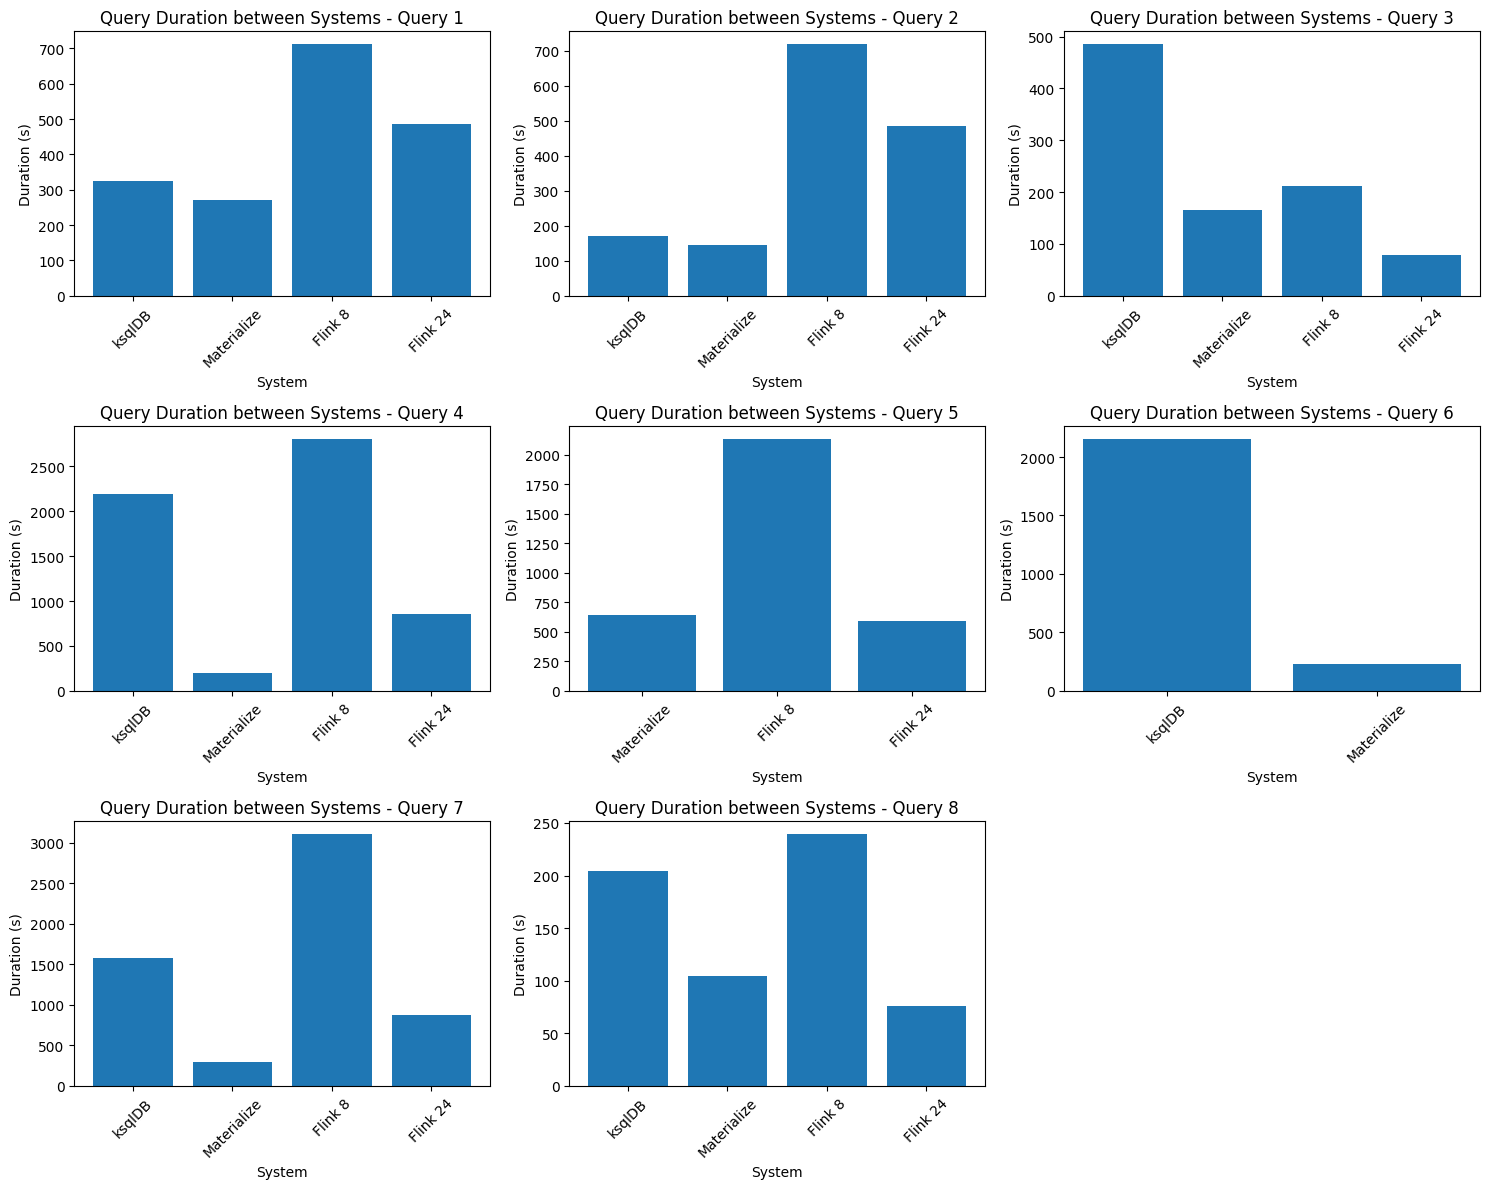

In [40]:
column = 'Duration (s)'
title = 'Query Duration between Systems'

generate_comparison_multiple_plot(combined_df, column, title)

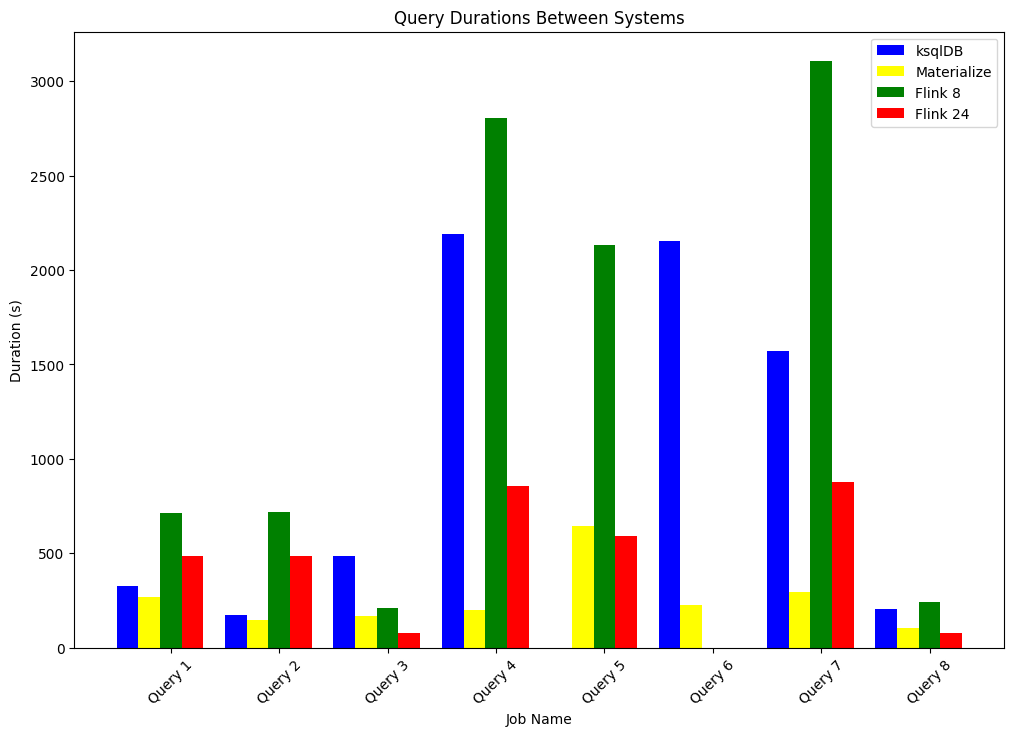

In [39]:
generate_comparison_plot(combined_df, 'Duration (s)', 'Query Durations Between Systems')

### Throughput (bytes/s)

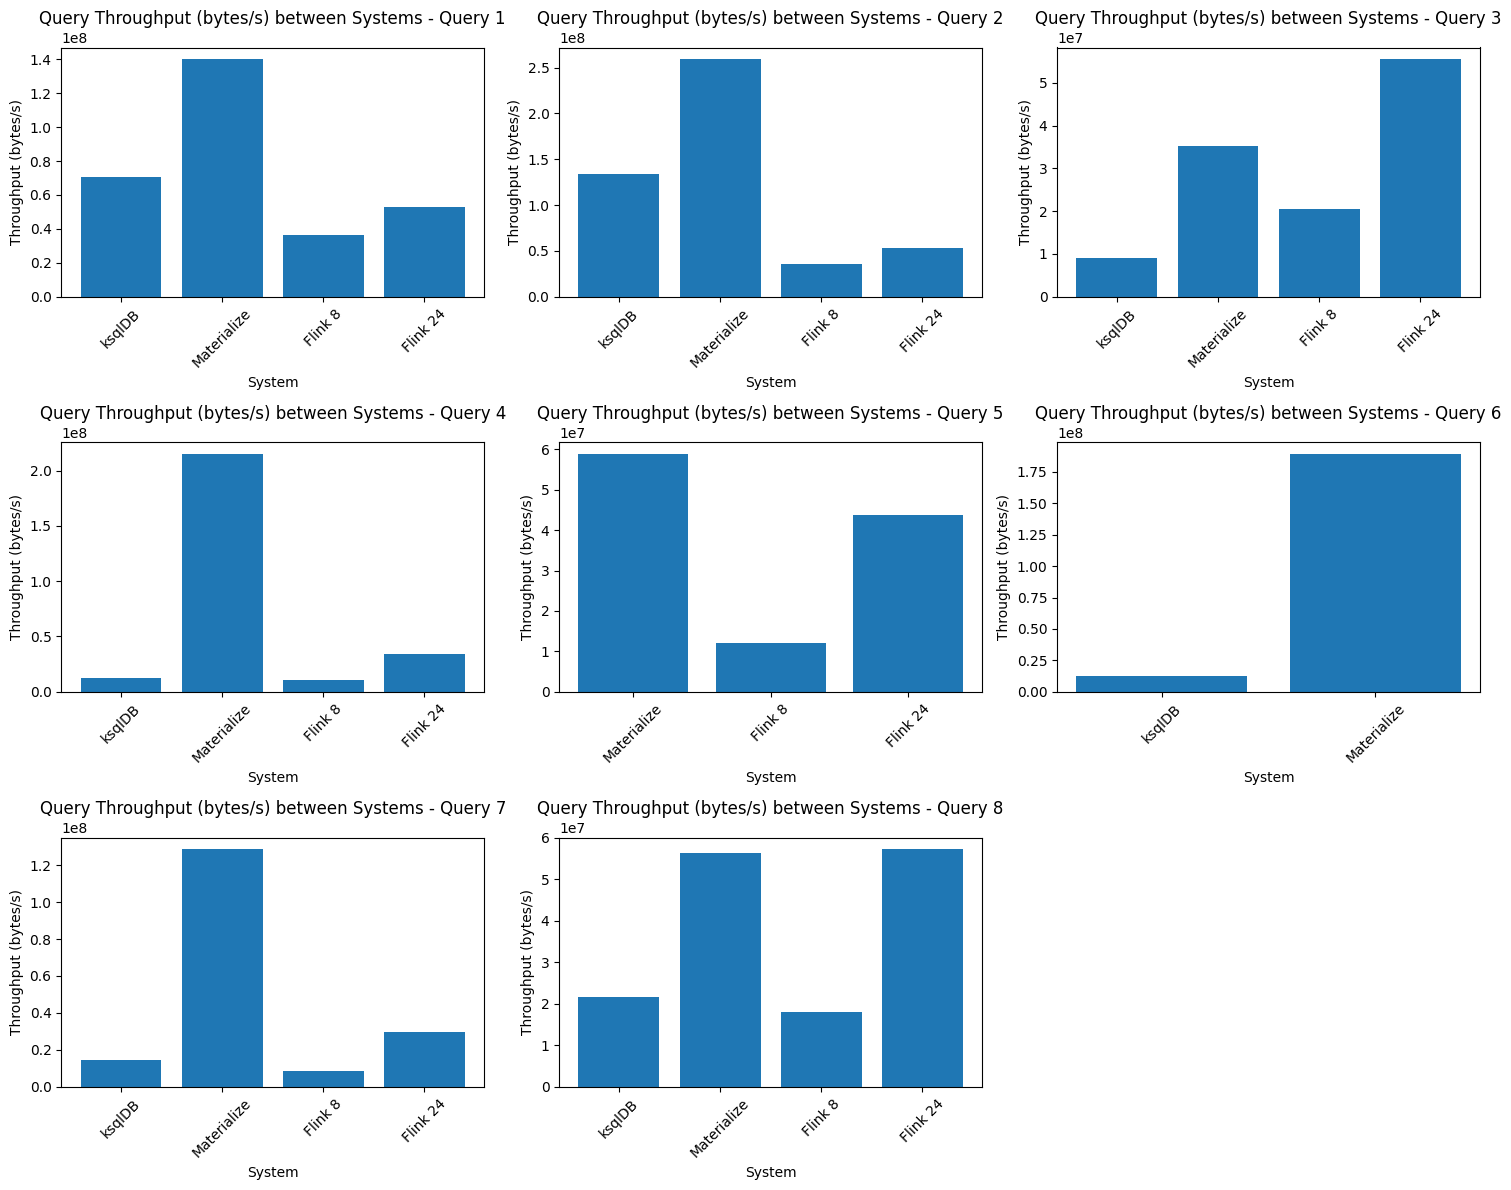

In [34]:
column = 'Throughput (bytes/s)'
title = 'Query Throughput (bytes/s) between Systems'

generate_comparison_multiple_plot(combined_df, column, title)

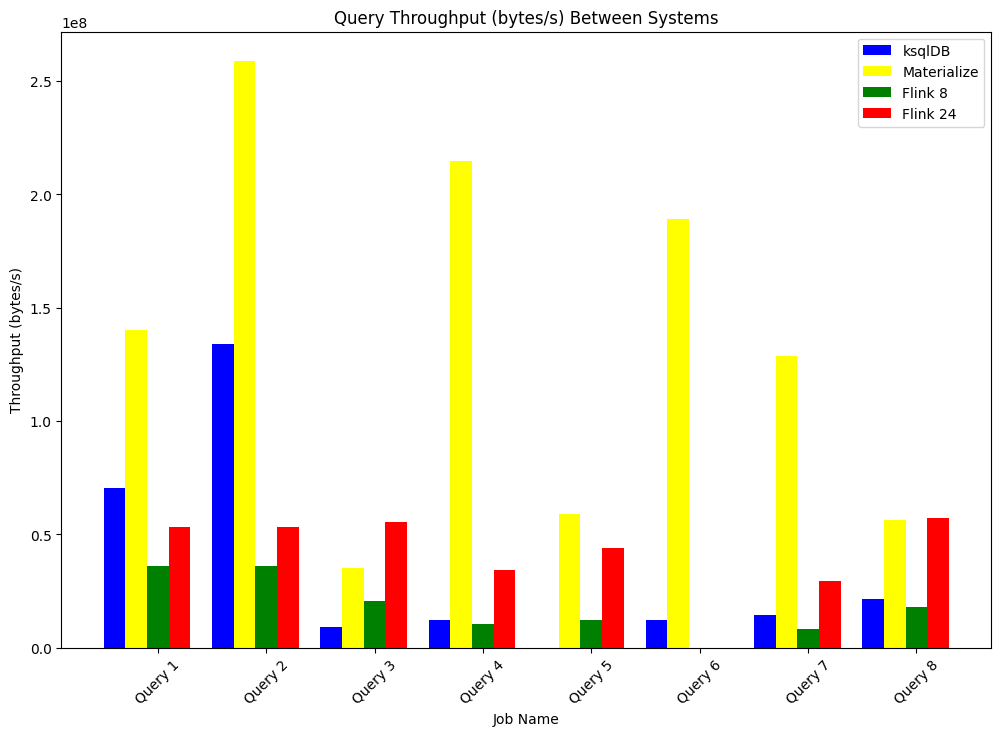

In [38]:
generate_comparison_plot(combined_df, 'Throughput (bytes/s)' , 'Query Throughput (bytes/s) Between Systems')

### Throughput (rows/s)

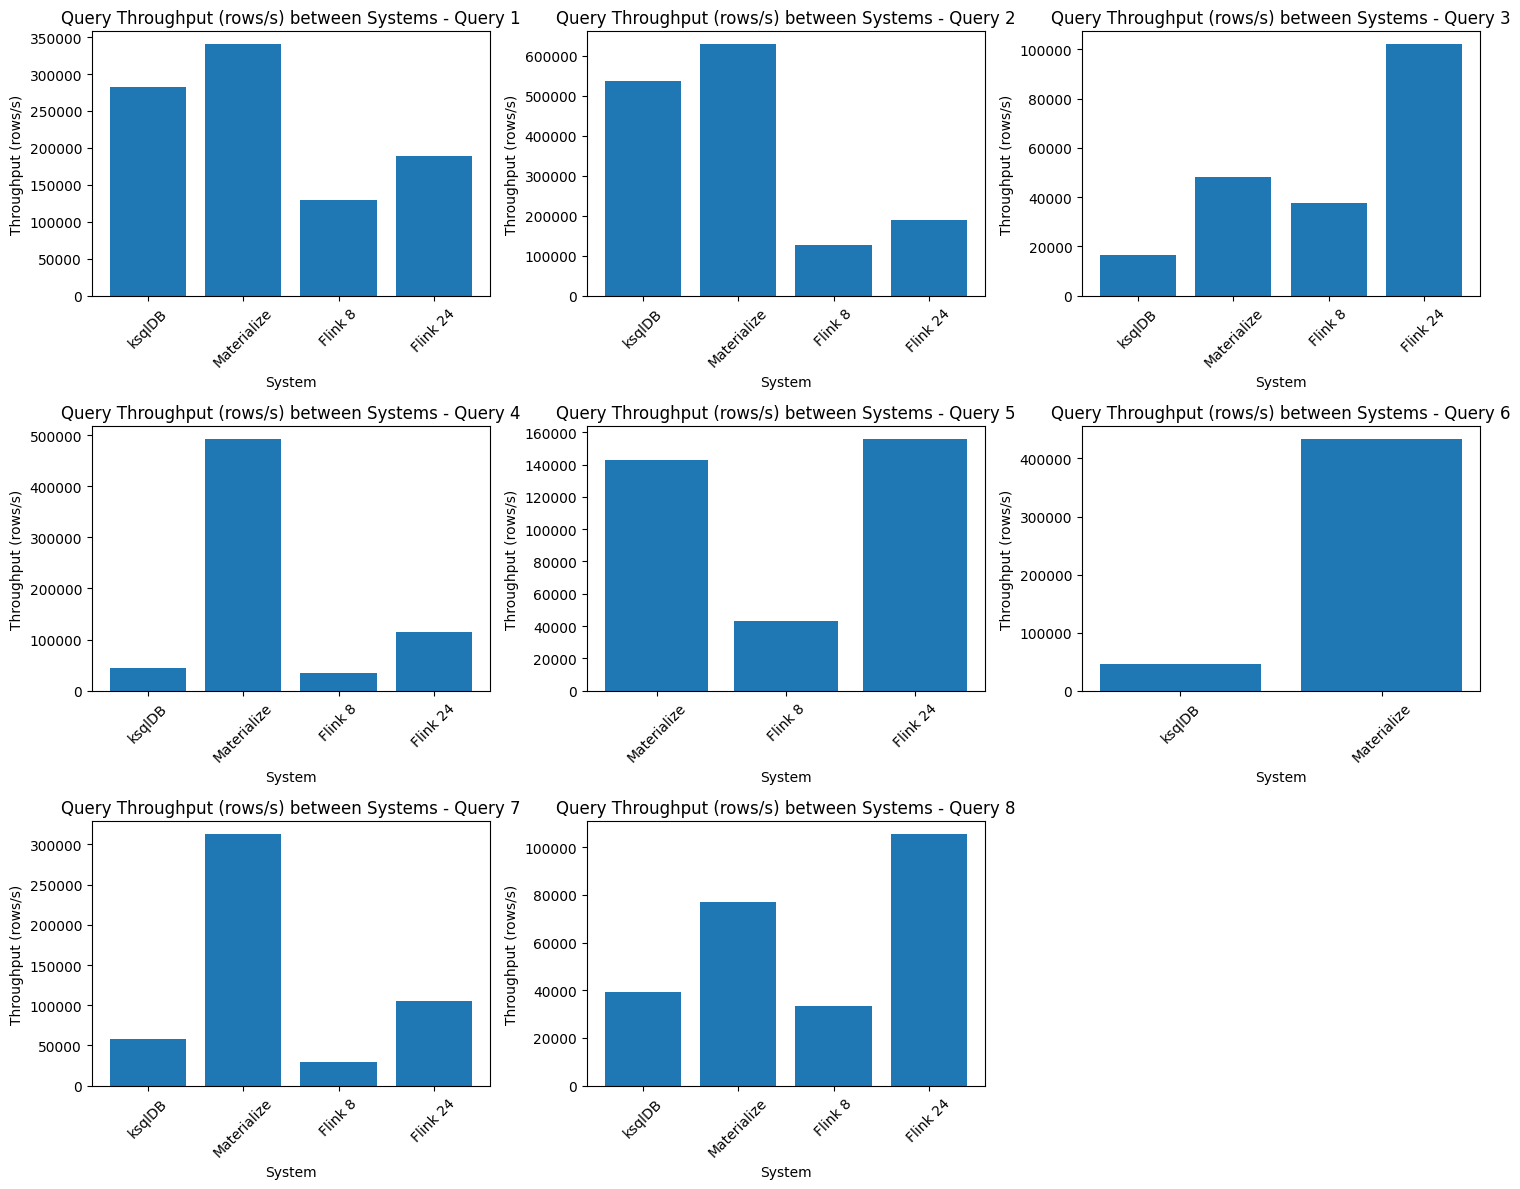

In [41]:
column = 'Throughput (rows/s)'
title = 'Query Throughput (rows/s) between Systems'

generate_comparison_multiple_plot(combined_df, column, title)

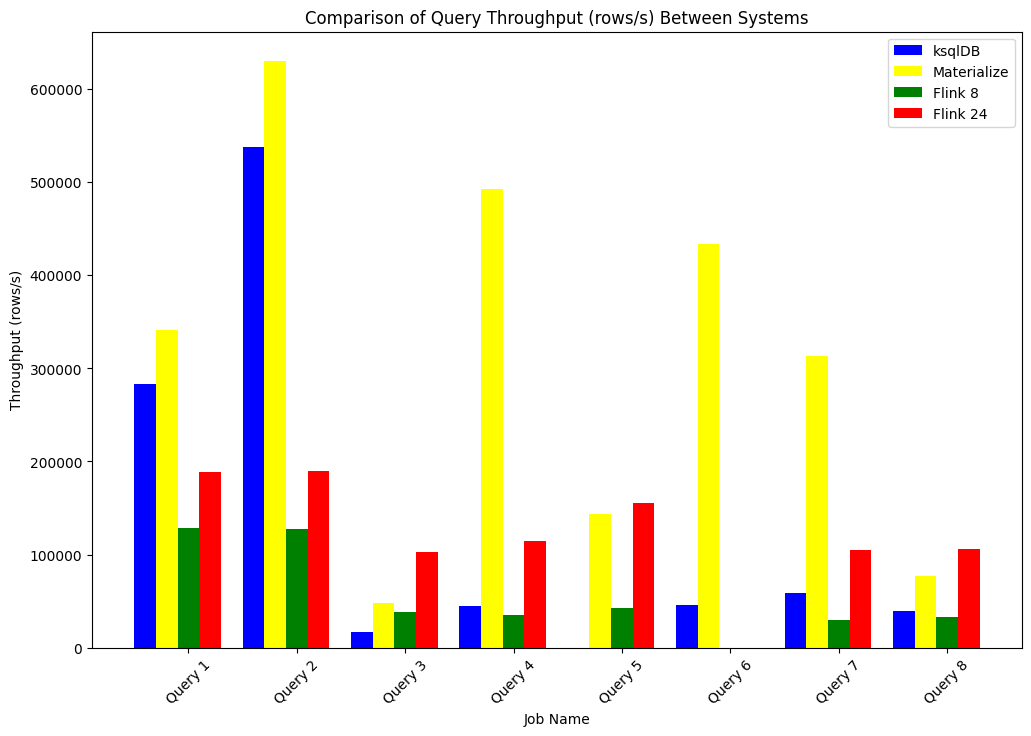

In [37]:
generate_comparison_plot(combined_df, 'Throughput (rows/s)' , 'Query Throughput (rows/s) Between Systems')